# Classify 15 Fruits with TensorFlow (acc: 99,6%)

<img src="https://i.imgur.com/GCj678V.pnghttps://i.imgur.com/GCj678V.png" align = "left">

# Table of contents

[<h3>1. Load and visualize the dataset</h3>](#1)

[<h3>2. Train the neural network from scratch with Keras and w/o generator</h3>](#2)

[<h3>3. Competition 27 pre-trained architectures - May the best win</h3>](#3)

[<h3>4. Train the architecture with the best results</h3>](#4)

[<h3>5. Example of predictions</h3>](#5)

# Data collection
The database used in this study is comprising of 44406 fruit images, which we collected
in a period of 6 months. The images where made with in our lab’s environment under different
scenarios which we mention below. We captured all the images on a clear background with
resolution of 320×258 pixels. We used HD Logitech web camera to took the pictures. During
collecting this database, we created all kind of challenges, which, we have to face in real-world
recognition scenarios in supermarket and fruit shops such as light, shadow, sunshine, pose
variation, to make our model robust for, it might be necessary to cope with illumination
variation, camera capturing artifacts, specular reflection shading and shadows. We tested our
model’s robustness in all scenarios and it perform quit well.
All of images were stored in RGB color-space at 8 bits per channel. The images were
gathered at various day times of the day and in different days for the same category. These
features increase the dataset variability and represent more realistic scenario. The Images had
large variation in quality and lighting. Illumination is one of those variations in imagery. In fact,
illumination can make two images of same fruit less similar than two images of different kind
of fruits. We were used our own intelligent weight machine and camera to captured all images.
The fruit dataset was collected under relatively unconstrained conditions. There are also images
with the room light on and room lights off, moved the camera and intelligent weight machine
near to the windows of our lab than open windows, closed windows, open window curtains,
closed curtains. For a real application in a supermarket, it might be necessary to cope with
illumination variation, camera capturing artifacts, specular reflection shading and shadows.
Below are the few conditions which we were considered during collected dataset.
- Pose Variations with different categories of fruits
- Variability on the number of elements of fruits
- Used HD camera with 5-megapixel snapshots
- Same color but different Category fruits images with illumination variation
- Cropping and partial occlusion
- Different color same category fruit images
- Different lighting conditions (e.g. fluorescent, natural light some of the fruits shops
- and supermarkets are without sunshine so it can easily affect the recognition system
- Six different kind of apple fruit images
- Three categories of mango fruit with specular reflecting shading and shadows
- Three categories of Kiwi fruit images
- Natural and artificial lighting effect on images
- Partial occlusion with hand



# 1. Load and visualize the dataset<a class="anchor" id="1"></a>

The database used in this study is comprising of 70549 fruit images, which were collected in a period of 6 months. The images where made with in a lab’s environment under different scenarios which we mention below. All the images were captured on a clear background with resolution of 320×258 pixels.

<strong><u>Type of fruits in the dataset:</u></strong>
- Apple
- Banana
- Carambola
- Guava
- Kiwi
- Mango
- Orange
- Peach
- Pear
- Persimmon
- Pitaya
- Plum
- Pomegranate
- Tomatoes
- muskmelon

In [1]:
# Load the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
np.random.seed(0) # Add random seed of training for reproducibility

def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [2]:
# Load the paths on the images
images = []
dirp = "/kaggle/input/fruit-recognition/"
for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
            
# Create a dataframe with the paths and the label for each fruit
df = pd.DataFrame(images, columns = ["fruit", "path"])

# Shuffle the dataset
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Assign to each fruit a specific number
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

# Visualize the resulting dataframe
df.head()

{'Apple': 0, 'Banana': 1, 'Carambola': 2, 'Guava': 3, 'Kiwi': 4, 'Mango': 5, 'Orange': 6, 'Peach': 7, 'Pear': 8, 'Persimmon': 9, 'Pitaya': 10, 'Plum': 11, 'Pomegranate': 12, 'Tomatoes': 13, 'muskmelon': 14}


fruit                                               path  label
0  Pomegranate  /kaggle/input/fruit-recognition/Pomegranate/Po...     12
1  Pomegranate  /kaggle/input/fruit-recognition/Pomegranate/Po...     12
2         Kiwi  /kaggle/input/fruit-recognition/Kiwi/kiwi A/Ki...      4
3        Mango  /kaggle/input/fruit-recognition/Mango/Mango003...      5
4        Guava  /kaggle/input/fruit-recognition/Guava/Guava to...      3

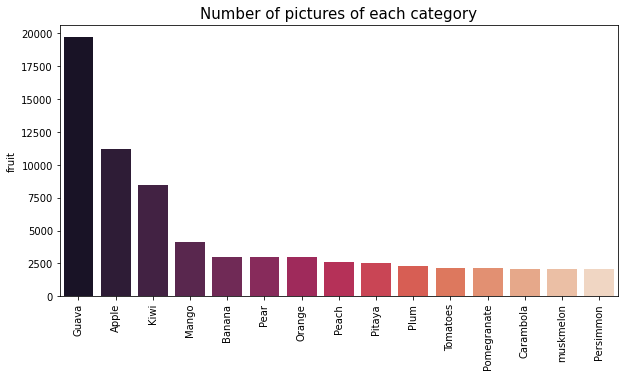

In [3]:
# Display the number of pictures of each category
vc = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

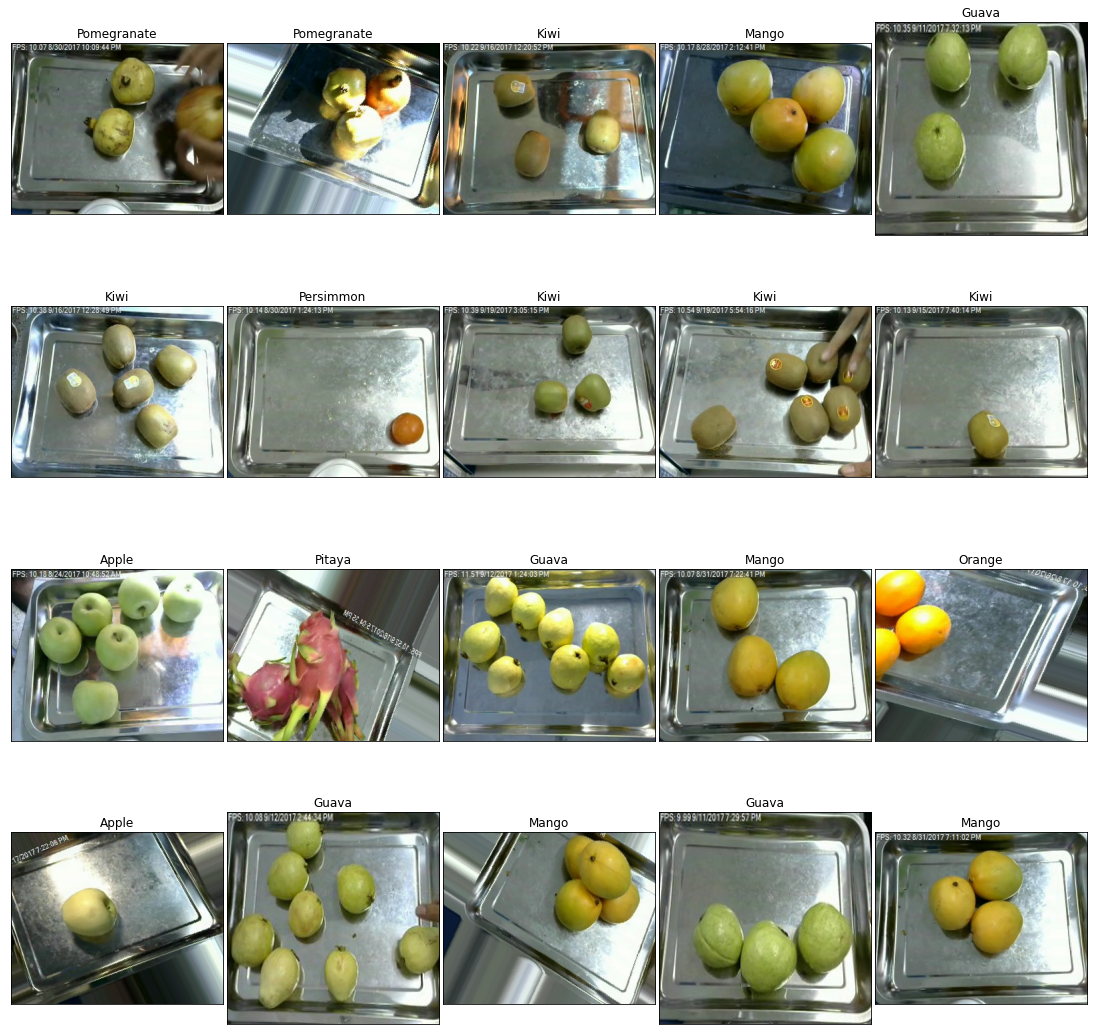

In [4]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

# 2. Train the neural network from scratch with Keras and w/o generator<a class="anchor" id="2"></a><a class="anchor" id="1"></a>

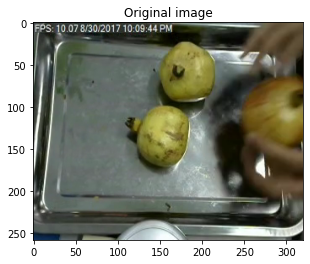

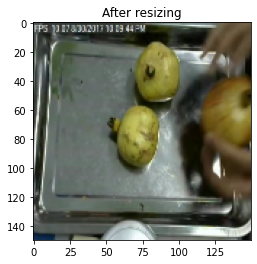

In [5]:
# The pictures will be resized to have the same size for the neural network
img = plt.imread(df.path[0])
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (150,150)))
plt.title("After resizing")
plt.show()

## 2.1. Create and train the CNN Model<a class="anchor" id="2"></a>

In [6]:
def cut_df(df, number_of_parts, part):
# Return a part of the dataframe
# For example, if a dataframe has 10 rows and we want to return a part of them
# if it is cut in two, it will return the first 5 rows or the last 5 rows depending the part wanted

# Args:
#     df (pandas.DataFrame): The dataframe to cut a part of
#     number_of_parts (int): In how many parts should the dataframe be cut
#     part (int): The part of the dataframe to return

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

def load_img(df):
# Load the images using their contained in the dataframe df
# Return a list of images and a list with the labels of the images
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [7]:
def create_model():
    shape_img = (150,150,3)
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [8]:
def from_categorical(lst):
    """
    Inverse of to_categorical
    Example: [[0,0,0,1,0], [1,0,0,0,0]] => [3,0]
    """
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
# Display prediction statistics
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")
    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [9]:
model = create_model()
hists = []

# The model will be trained with one part of the data.
# There isn't enough RAM on Kaggle to handle all the data.
# In the next chapter a generator will be used
# to "feed" the ANN step by step.
# For Kaggle set divisor <= 5. 1/5 of the data will be used
divisor = 5

start_time = time.time()
X_train, y_train = load_img(cut_df(df,divisor,1))
y_train = to_categorical(y_train)

# If the ANN doesn't increase its prediction accuracy on the validation data after 
# 10 epochs, stop the training and take the best of the ANN.
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split = 0.1, verbose = 1)
hists.append(model.history.history)


Epoch 1/100
100/100 [==============================] - 14s 68ms/step - loss: 2.5547 - accuracy: 0.2605 - val_loss: 2.1526 - val_accuracy: 0.3310
Epoch 2/100
100/100 [==============================] - 6s 59ms/step - loss: 2.0463 - accuracy: 0.3519 - val_loss: 1.7665 - val_accuracy: 0.3777
Epoch 3/100
100/100 [==============================] - 6s 61ms/step - loss: 1.7158 - accuracy: 0.4341 - val_loss: 1.4855 - val_accuracy: 0.5074
Epoch 4/100
100/100 [==============================] - 6s 58ms/step - loss: 1.4328 - accuracy: 0.5348 - val_loss: 0.7353 - val_accuracy: 0.7562
Epoch 5/100
100/100 [==============================] - 6s 61ms/step - loss: 1.1815 - accuracy: 0.6325 - val_loss: 0.5871 - val_accuracy: 0.7888
Epoch 6/100
100/100 [==============================] - 6s 58ms/step - loss: 0.7616 - accuracy: 0.7378 - val_loss: 0.4704 - val_accuracy: 0.8292
Epoch 7/100
100/100 [==============================] - 6s 59ms/step - loss: 0.5194 - accuracy: 0.8222 - val_loss: 0.4121 - val_accuracy

In [10]:
# Run the garbage collector
gc.collect()

8140

In [11]:
time_model = time.time() - start_time
print(f"Time to train the model: {int(time_model)} seconds")

Time to train the model: 458 seconds


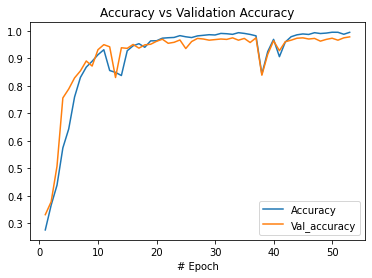

In [12]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

## 2.3. Predictions<a class="anchor" id="3"></a>

In [13]:
import warnings
warnings.filterwarnings("ignore")

# Make predictions with the model using the last 1/20 part of the dataset
X, y = load_img(cut_df(df, 20, 20))
pred = model.predict_classes(X)
y_test = to_categorical(y)

# Display statistics
display_stats(y_test, pred)

### Result of the predictions using 3527 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       545
           1       0.98      0.93      0.96       129
           2       1.00      1.00      1.00       109
           3       0.99      1.00      1.00      1027
           4       0.99      1.00      1.00       395
           5       1.00      0.99      0.99       210
           6       0.99      0.99      0.99       151
           7       0.90      0.99      0.94       127
           8       0.96      0.98      0.97       131
           9       0.99      0.98      0.99       104
          10       0.99      0.99      0.99       131
          11       1.00      1.00      1.00       107
          12       0.99      0.97      0.98       129
          13       0.96      0.91      0.93       129
          14       0.97      0.87      0.92       103

    accuracy                           0.98      3527


# Accuracy: 0.97987

## 2.4. Visualize the result with pictures of fruits

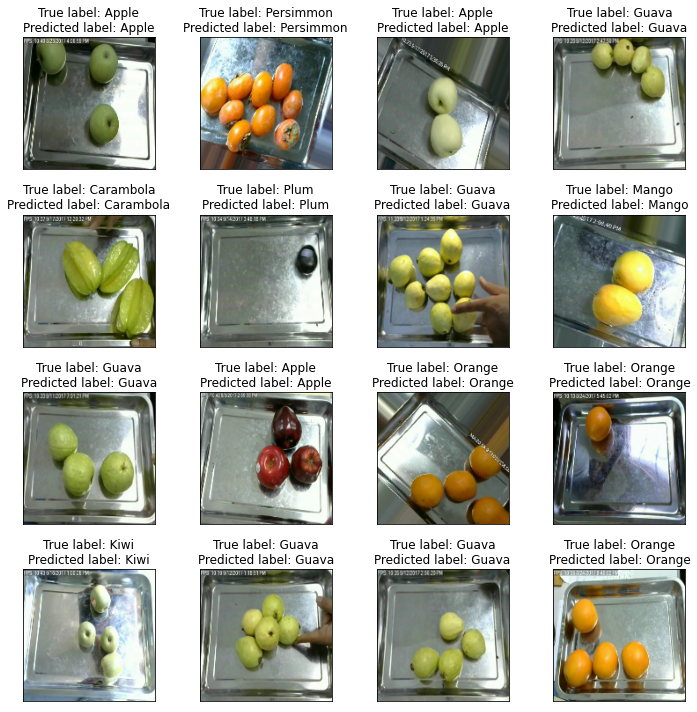

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X[-i])
    ax.set_title(f"True label: {fruit_names[y[-i]]}\nPredicted label: {fruit_names[pred[-i]]}")

plt.tight_layout()
plt.show()

<strong>The predictions are very good with around 97% accuracy using only 1/5 of the dataset to train the model.</strong>

# 3. Competition of 27 pre-trained architectures - May the best win<a class="anchor" id="3"></a><a class="anchor" id="1"></a>
*Transfer Learning, Data Generator, Data Augmentation*

More info about the architectures under: [Module: tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=enhttps%3A%2F%2Fwww.tensorflow.org%2Fapi_docs%2Fpython%2Ftf%2Fkeras%2Fapplications%3Fhl%3Den)

In [15]:
# Use only 5% on the pictures to speed up the training
train_df,test_df = train_test_split(df[['path','fruit']].sample(frac=0.05,random_state=0), test_size=0.2,random_state=0)

In [16]:
import tensorflow as tf
from time import perf_counter

def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
#         rotation_range=30, # Uncomment those lines to use data augmentation
#         zoom_range=0.15,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.15,
#         horizontal_flip=True,
#         fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
#         rotation_range=30, # Uncomment those lines to use data augmentation
#         zoom_range=0.15,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.15,
#         horizontal_flip=True,
#         fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(15, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
#     "NASNetLarge": {"model":tf.keras.applications.NASNetLarge, "perf":0}, Deleted because the input shape has to be another one
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 2539 validated image filenames belonging to 15 classes.
Found 282 validated image filenames belonging to 15 classes.
Found 706 validated image filenames belonging to 15 classes.


29089792/29084464 [==============================] - 0s 0us/step
DenseNet121          trained in 32.91 sec
9412608/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 18.78 sec
51879936/51877672 [==============================] - 0s 0us/step
DenseNet169          trained in 28.42 sec
74842112/74836368 [==============================] - 1s 0us/step
DenseNet201          trained in 29.25 sec
16711680/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 22.87 sec
27025408/27018416 [==============================] - 0s 0us/step
EfficientNetB1       trained in 25.25 sec
31793152/31790344 [==============================] - 0s 0us/step
EfficientNetB2       trained in 25.06 sec
43941888/43941136 [==============================] - 0s 0us/step
Ef

In [17]:
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.fruit)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
#     printmd(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

In [18]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

model  val_accuracy  accuracy  Training time (sec)
0         DenseNet201        0.9504    0.9448                29.25
1         MobileNetV2        0.9184    0.9405                18.78
2           MobileNet        0.9043    0.9150                17.83
3            Xception        0.8901    0.9093                20.14
4         DenseNet169        0.9433    0.9051                28.42
5         DenseNet121        0.8901    0.8994                32.91
6         ResNet152V2        0.8972    0.8909                30.39
7          ResNet50V2        0.8688    0.8853                19.22
8         ResNet101V2        0.8262    0.8612                24.83
9         InceptionV3        0.8191    0.8329                21.51
10       NASNetMobile        0.8121    0.8286                31.78
11  InceptionResNetV2        0.8191    0.8173                30.62
12              VGG19        0.5177    0.5467                17.91
13              VGG16        0.5000    0.5425                24.71
14          ResNet152        0.4007    0.4235                28.83
15           ResNet50        0.3723    0.3796                19.94
16          ResNet101        0.3440    0.3725                25.26
17   MobileNetV3Large        0.3404    0.3584                20.31
18     EfficientNetB2        0.2943    0.2847                25.06
19     EfficientNetB3        0.2943    0.2847                27.35
20     EfficientNetB0        0.2943    0.2847                22.87
21     EfficientNetB1        0.2943    0.2847                25.25
22     EfficientNetB7        0.2943    0.2847                30.49
23     EfficientNetB6        0.2943    0.2847                29.82
24     EfficientNetB5        0.2943    0.2847                31.25
25     EfficientNetB4        0.2943    0.2847                29.54
26   MobileNetV3Small        0.2943    0.2847                22.39

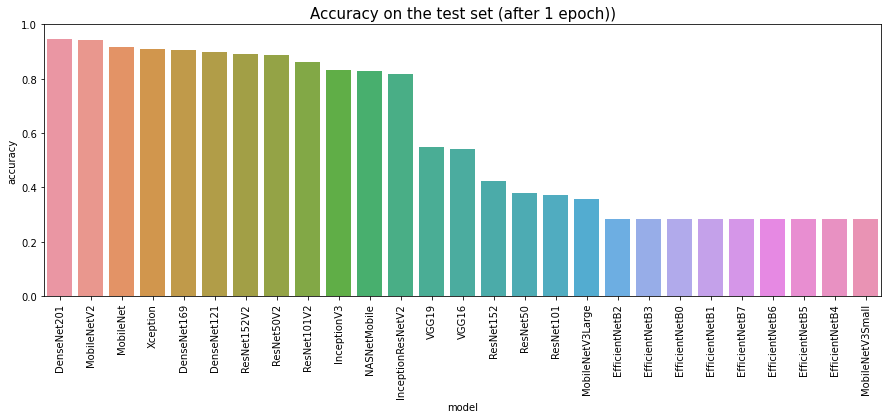

In [19]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

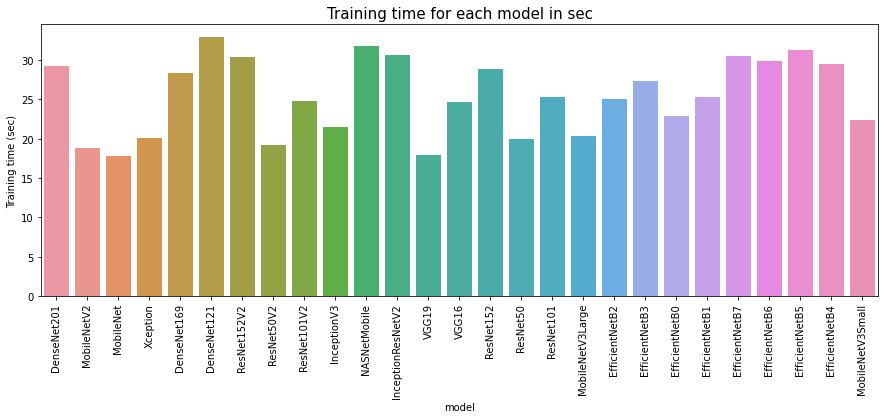

In [20]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

# 4. Train the architecture with the best results<a class="anchor" id="4"></a>

In [21]:
# Split into train/test datasets using all of the pictures
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)

# Create the generator
train_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 57145 validated image filenames belonging to 15 classes.
Found 6349 validated image filenames belonging to 15 classes.
Found 7055 validated image filenames belonging to 15 classes.


In [22]:
# Create and train the model
model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True)]
                    )

Epoch 1/5
1786/1786 [==============================] - 636s 349ms/step - loss: 0.2261 - accuracy: 0.9365 - val_loss: 0.0121 - val_accuracy: 0.9964
Epoch 2/5
1786/1786 [==============================] - 636s 356ms/step - loss: 0.0181 - accuracy: 0.9943 - val_loss: 0.0100 - val_accuracy: 0.9964
Epoch 3/5
1786/1786 [==============================] - 614s 344ms/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.0187 - val_accuracy: 0.9934


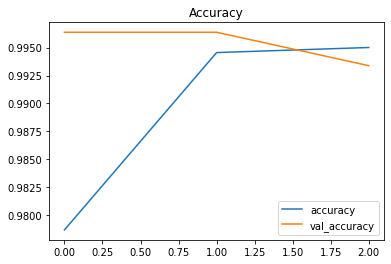

In [23]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

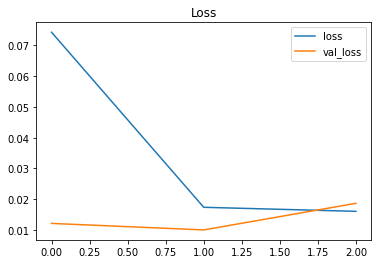

In [24]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [25]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.fruit)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

# Accuracy on the test set: 99.62%

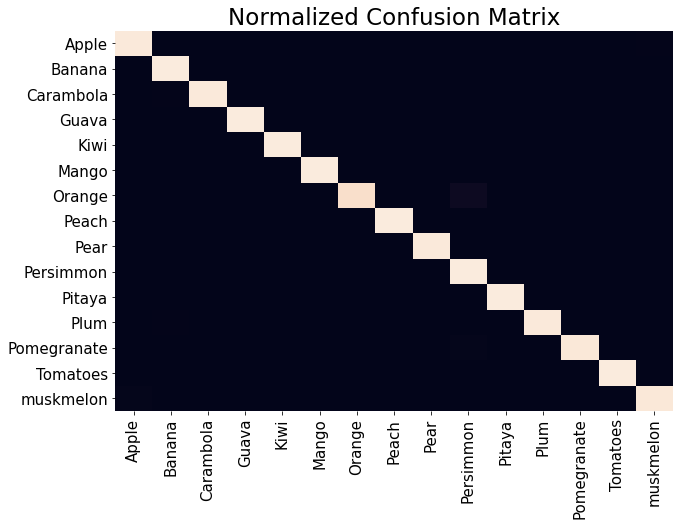

In [26]:
# Display a confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# 5. Example of prediction<a class="anchor" id="5"></a>

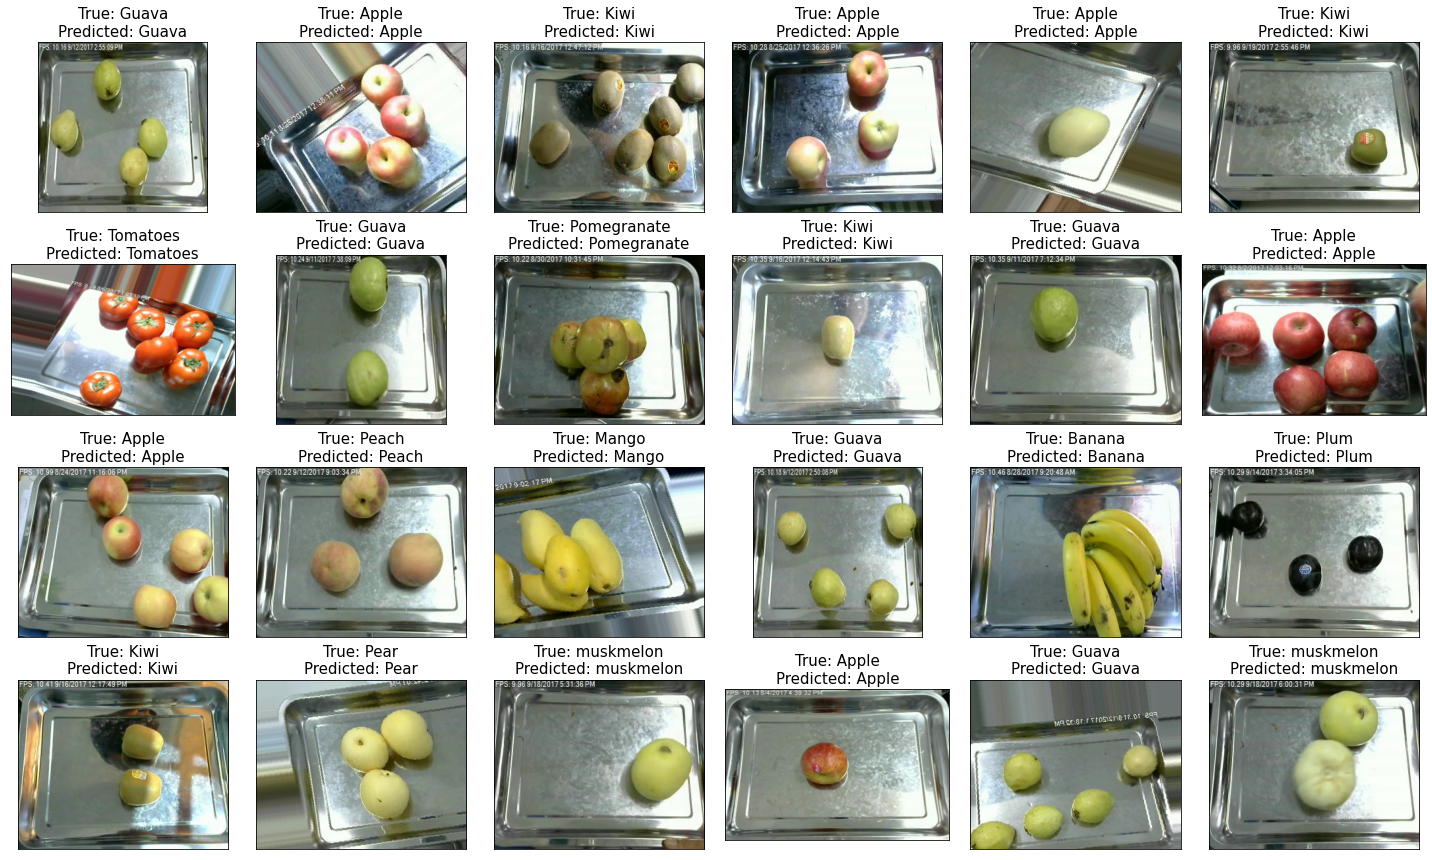

In [27]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.path.iloc[i]))
    ax.set_title(f"True: {test_df.fruit.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()